In [1]:
#Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

gen_dir = "/Users/w20009829/OneDrive - Northumbria University - Production Azure AD/Term3/"

#gen_dir = "/Users/xaichotic/Library/CloudStorage/OneDrive-NorthumbriaUniversity-ProductionAzureAD/Term3/"


In [2]:
#loading the data

data_dir = gen_dir + "Data_ALL/EDA/EDA_csv_files2_labeled_baseline6_neurokit/" #using baseline6 EDA

#creating output directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data = []
labels = []
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        label = int(filename.split("_")[2].split(".")[0])
        signal_df = pd.read_csv(filepath)
        signal_values = signal_df.to_numpy()
        data.append(signal_values)
        labels.append(label)
        
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [3]:
print(data.shape)
print(labels.shape)

(66, 1440, 1)
(66,)


In [4]:
from imblearn.under_sampling import RandomUnderSampler

# Flatten the data array to a 2D array
data_2d = data.reshape((data.shape[0], -1))

# Print class counts before downsampling
print("Class counts before downsampling:", Counter(labels))

# Random undersampling of the majority class
rus = RandomUnderSampler(random_state=42)
data_resampled, labels_resampled = rus.fit_resample(data_2d, labels)

# Reshape the data array back to the original shape
data_resampled = data_resampled.reshape((data_resampled.shape[0], data.shape[1], data.shape[2]))

# Print class counts after downsampling
print("Class counts after downsampling:", Counter(labels_resampled))

Class counts before downsampling: Counter({0: 47, 1: 19})
Class counts after downsampling: Counter({0: 19, 1: 19})


In [5]:
#just saving it back to data and labels

data = data_resampled
labels = labels_resampled

print(data.shape)
print(labels.shape)

(38, 1440, 1)
(38,)


In [6]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30, 1440, 1)
(30,)
(8, 1440, 1)
(8,)


In [8]:
# Z-score normalization for baseline_6
from scipy.stats import zscore

# Normalize the data
X_train = np.array([zscore(x, axis=None) for x in X_train])
X_test = np.array([zscore(x, axis=None) for x in X_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(30, 1440, 1)
(30,)
(8, 1440, 1)
(8,)


In [ ]:
# from keras.utils import plot_model
# from keras.models import Sequential, Model
# from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Input, Bidirectional

# input_shape = (100, 100, 3)
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(1, activation='sigmoid'))

# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [10]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [13]:
#Basic CNN

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import LeakyReLU, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

filter_size = 32
kernel_size = 3
batch_size = 8

lstm_units = 32

# With biLSTM layer
model = Sequential()
model.add(Conv1D(filter_size, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Conv1D(filter_size*2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filter_size*4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Flatten())
model.add(Dense(512, activation='relu')) #fixed 128
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')) #fixed 128
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Using RMSprop
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate = 0.001), metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1438, 32)          128       
                                                                 
 batch_normalization_6 (Batc  (None, 1438, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 1436, 64)          6208      
                                                                 
 batch_normalization_7 (Batc  (None, 1436, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_8 (Conv1D)           (None, 1434, 128)         24704     
                                                                 
 batch_normalization_8 (Batc  (None, 1434, 128)       

1/1 [==============================] - 0s 390ms/step
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.60      0.60      0.60         5

    accuracy                           0.50         8
   macro avg       0.47      0.47      0.47         8
weighted avg       0.50      0.50      0.50         8

Confusion matrix:
 [[1 2]
 [2 3]]
ROC-AUC score: 0.33333333333333337


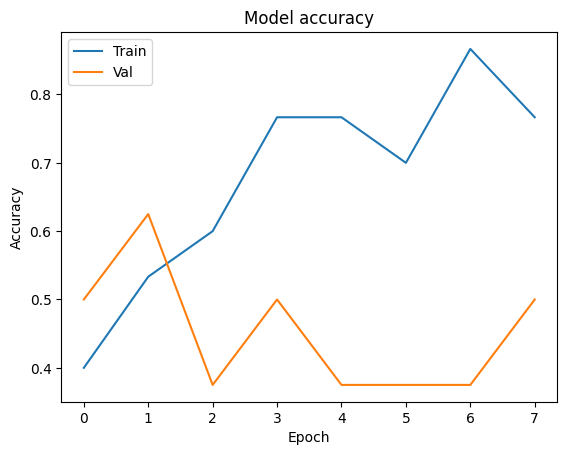

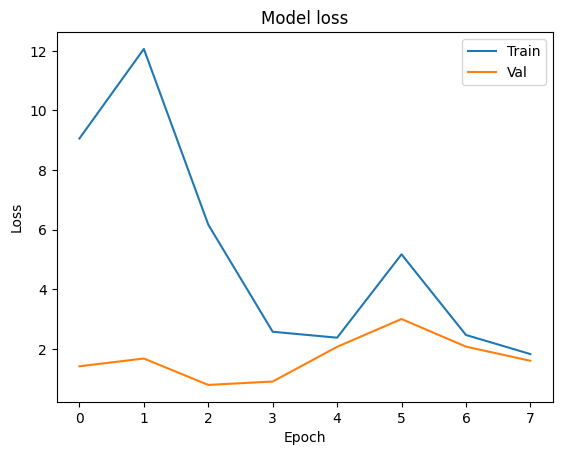

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print('Confusion matrix:\n', cm)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC score:', roc_auc)

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
#Basic CNN

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import LeakyReLU, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

filter_size = 32
kernel_size = 3
batch_size = 8

lstm_units = 32

# With biLSTM layer
model = Sequential()
model.add(Conv1D(filter_size, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Conv1D(filter_size*2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filter_size*4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='relu')) #fixed 128
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Using RMSprop
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

cross validation

In [18]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Set the random seeds for reproducibility
# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

filter_size = 32
kernel_size = 3
batch_size = 8
LSTM_unit = 32
num_folds = 10
n_epochs = 20

# Define the optimizer
#optimizer = Adam(learning_rate=0.01)

# Define the CNN model
def create_model():
# With biLSTM layer
    model = Sequential()
    model.add(Conv1D(filter_size, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Conv1D(filter_size*2, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filter_size*4, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(512, activation='relu')) #fixed 128
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu')) #fixed 128
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    return model

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

#K-fold cross-validation lists
score_list = []
precision_list = []
recall_list = []
f1_score_list = []
confusion_matrix_list = []
specificity_list = []
ROC_AUC_list = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
    #splitting the data into train and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
    
    #defining the early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    #training the model for this fold
    model = create_model()
    history = model.fit(X_train_fold, y_train_fold, epochs=n_epochs, batch_size=batch_size, 
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stop], verbose=1)
    
    #predicting the classes for the validation set for this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    #calculating precision, recall, specificity, F1 score, AUC, and confusion matrix for this fold
    precision_list.append(precision_score(y_val_fold, y_pred_classes))
    recall_list.append(recall_score(y_val_fold, y_pred_classes))
    f1_score_list.append(f1_score(y_val_fold, y_pred_classes))
    #tp, fp, fn, tn = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred_classes).ravel()
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)
    ROC_AUC_list.append(roc_auc_score(y_val_fold, y_pred))
    confusion_matrix_list.append(confusion_matrix(y_val_fold, y_pred_classes))

    #evaluating the model on the test set for this fold
    #_, test_acc = model.evaluate(X_test, y_test)
    _, test_acc = model.evaluate(X_val_fold, y_val_fold)

    score_list.append(test_acc)
    
    #printing the metrics and confusion matrix for this fold
    print(f'Fold {fold + 1}: Accuracy = {test_acc:.4f}, \
      Precision = {precision_list[-1]:.4f}, \
      Recall = {recall_list[-1]:.4f}, \
      Specificity = {specificity_list[-1]:.4f}, \
      AUC = {ROC_AUC_list[-1]:.4f}, \
      F1 Score = {f1_score_list[-1]:.4f}')
    print(f'Confusion matrix:\n{confusion_matrix_list[-1]}')
    
#Print the average scores for all folds

print(f'Average Accuracy: {np.mean(score_list):.4f} +/- {np.std(score_list):.4f}')
print(f'Average Precision: {np.mean(precision_list):.4f} +/- {np.std(precision_list):.4f}')
print(f'Average Recall/Sensitivity: {np.mean(recall_list):.4f} +/- {np.std(recall_list):.4f}')
print(f'Average Specificity: {np.mean(specificity_list):.4f} +/- {np.std(specificity_list):.4f}')
print(f'Average F1-score: {np.mean(f1_score_list):.4f} +/- {np.std(f1_score_list):.4f}')
print(f'Average ROC_AUC score: {np.mean(ROC_AUC_list):.4f} +/- {np.std(ROC_AUC_list):.4f}')

#printing the overall confusion matrix

overall_cm = np.sum(confusion_matrix_list, axis=0)
print(f'Overall confusion matrix:\n{overall_cm}')

Epoch 1/20
4/4 [==============================] - 4s 580ms/step - loss: 6.7698 - accuracy: 0.3333 - val_loss: 0.6559 - val_accuracy: 0.6667
Epoch 2/20
4/4 [==============================] - 2s 432ms/step - loss: 6.2139 - accuracy: 0.6296 - val_loss: 0.8249 - val_accuracy: 0.6667
Epoch 3/20
4/4 [==============================] - 2s 435ms/step - loss: 9.3195 - accuracy: 0.5926 - val_loss: 0.9535 - val_accuracy: 0.6667
Epoch 4/20
4/4 [==============================] - 2s 456ms/step - loss: 2.2247 - accuracy: 0.7407 - val_loss: 2.6202 - val_accuracy: 0.3333
Epoch 4: early stopping
1/1 [==============================] - 0s 77ms/step - loss: 0.6559 - accuracy: 0.6667
Fold 1: Accuracy = 0.6667,       Precision = 0.6667,       Recall = 1.0000,       Specificity = 0.0000,       AUC = 0.5000,       F1 Score = 0.8000
Confusion matrix:
[[0 1]
 [0 2]]
Epoch 1/20
4/4 [==============================] - 5s 584ms/step - loss: 5.3414 - accuracy: 0.4815 - val_loss: 0.5784 - val_accuracy: 0.6667
Epoch 2/2

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
4/4 [==============================] - 4s 582ms/step - loss: 6.2957 - accuracy: 0.4815 - val_loss: 0.7792 - val_accuracy: 0.6667
Epoch 2/20
4/4 [==============================] - 2s 423ms/step - loss: 11.8576 - accuracy: 0.2963 - val_loss: 1.0357 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 2s 422ms/step - loss: 1.3649 - accuracy: 0.8889 - val_loss: 1.4393 - val_accuracy: 0.0000e+00
Epoch 4/20
4/4 [==============================] - 2s 437ms/step - loss: 4.7765 - accuracy: 0.6296 - val_loss: 1.3362 - val_accuracy: 0.6667
Epoch 4: early stopping
1/1 [==============================] - 0s 76ms/step - loss: 0.7792 - accuracy: 0.6667
Fold 6: Accuracy = 0.6667,       Precision = 0.5000,       Recall = 1.0000,       Specificity = 0.5000,       AUC = 1.0000,       F1 Score = 0.6667
Confusion matrix:
[[1 1]
 [0 1]]
Epoch 1/20
4/4 [==============================] - 5s 598ms/step - loss: 5.6507 - accuracy: 0.4815 - val_loss: 1.9430 - val_accuracy: 0.6667
Epoc

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
4/4 [==============================] - 4s 559ms/step - loss: 3.1366 - accuracy: 0.6296 - val_loss: 1.1520 - val_accuracy: 0.3333
Epoch 2/20
4/4 [==============================] - 2s 412ms/step - loss: 5.9880 - accuracy: 0.5556 - val_loss: 2.0061 - val_accuracy: 0.3333
Epoch 3/20
4/4 [==============================] - 2s 425ms/step - loss: 4.5937 - accuracy: 0.8148 - val_loss: 0.5233 - val_accuracy: 0.6667
Epoch 4/20
4/4 [==============================] - 2s 422ms/step - loss: 4.7619 - accuracy: 0.7778 - val_loss: 1.6103 - val_accuracy: 0.3333
Epoch 5/20
4/4 [==============================] - 2s 418ms/step - loss: 7.0243 - accuracy: 0.6296 - val_loss: 1.0264 - val_accuracy: 0.6667
Epoch 6/20
4/4 [==============================] - 2s 422ms/step - loss: 5.2245 - accuracy: 0.4444 - val_loss: 1.6740 - val_accuracy: 0.3333
Epoch 6: early stopping
1/1 [==============================] - 0s 67ms/step - loss: 0.5233 - accuracy: 0.6667
Fold 10: Accuracy = 0.6667,       Precision = 0.00

C:\Anaconda3\envs\xyrus\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
